# An example analysis using SCVI and Maxspin

In this notebook, I'll do an example run of maxspin leveraging SCVI's model to estimate "denoised" expression and its uncertainty.

In [1]:
from maxspin import spatial_information, pairwise_spatial_information
import numpy as np
import scanpy as sc
import squidpy as sq
import numpy as np
import torch
import scvi
import matplotlib.pyplot as plt
import seaborn
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/home/dcjones/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/dcjones/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
# Setting up some plotting options
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
}
</style>
""")

In [3]:
sc.set_figure_params(frameon=False, figsize=[5, 5], ipython_format="png")

First, we load some example Visium data, throwing out spots with an unusually low number of UMIs, and computing a spatial neighborhood graph, which is needed by Maxspin. Delaunay triangulation is usually sufficient for this, but using a distance cutoff might be preferable for highly irrugular samples.

In [4]:
#sample_id = "V1_Breast_Cancer_Block_A_Section_1"
#sample_id = "V1_Human_Lymph_Node"
sample_id = "V1_Adult_Mouse_Brain_Coronal_Section_1"
adata = sc.datasets.visium_sge(sample_id=sample_id)
adata = adata[np.asarray(adata.X.sum(axis=1))[:,0] > 1000,:].copy()
sq.gr.spatial_neighbors(adata, delaunay=True, coord_type="generic")

/home/dcjones/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dcjones/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sequencing depth in Visium experiments is often itself spatially varying, in part due to differences in tissue permeabilization, which can confound measurement of individual gene's spatial variability. Using SCVI's model partially, but not entirely normalizes this away, so it's preferable to using raw counts. An alternative is to use [vanity](https://github.com/dcjones/vanity), which is a more aggressive shrinkage model that will introduce fewer spuriously positive spatial information scores.

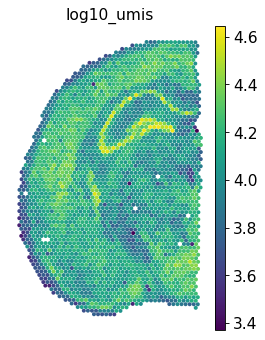

In [5]:
adata.obs["log10_umis"] = np.log10(np.squeeze(np.asarray(adata.X.sum(axis=1))))
sc.pl.spatial(adata, color="log10_umis", size=1.5, img_key=None)

We'll focus just on highly variable genes, as SCVI does a poor job on low expression genes anyway.

In [6]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=10000,
    subset=True,
    flavor="seurat_v3")

/home/dcjones/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Next we set up and train the SCVI model. There are various things you can do with this model, like integrate datasets, but here we just want reasonable expression estimates, with uncertainty estimates, that are largely unconfounded by sequencing depth.

In [7]:
scvi.model.SCVI.setup_anndata(adata)

In [8]:
model = scvi.model.SCVI(adata, n_latent=20)

In [9]:
model.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.82it/s, loss=3.99e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.16it/s, loss=3.99e+03, v_num=1]


To measure spatial information, we'll use log expression estimates from the SCVI model. We sample from the model's posterior to estimate the posterior mean and standard deviation.

In [10]:
posterior_samples = np.log(model.get_normalized_expression(return_numpy=True, return_mean=False, n_samples=20, library_size="latent"))
adata_scvi = adata.copy()
adata_scvi.X = np.mean(posterior_samples, axis=0)
adata_scvi.layers["std"] = np.std(posterior_samples, axis=0)

/home/dcjones/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Spatial Information

We can now estimate spatial information for every gene. We're treating the log-expression posteriors as Gaussian, which is a good enough approximation; maxspin is not particularly sensitive to distributional assumptions.

In [11]:
spatial_information(adata_scvi, prior="gaussian")

nsamples: 1
ngenes: 10013


/home/dcjones/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dcjones/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


ncells: [2894, 723, 361, 180]
chunk size: 8638


Scoring genes 8638 to 10013: 100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:07<00:00, 118.18it/s, mean_mi_bound=19.883389]


Taking a quick peak at some of the top spatially varying genes. Larger `spatial_information` scores indicate more spatial orginization. A score of 0 indicates no spatial organization. Here everything will be at least slightly positive. There are a few reasons for this:
  1. In Visium, there is typically some amount of diffusion of material between adjacent spots, which which appear as spatial auto-correlation.
  2. SCVI doesn't engage in aggressive shrinkage, so the expression estimates of low expression genes are subtly confounded by a spot's total number of UMIs, which is often itself spatially coherent.
  3. Essentially every gene displays some degree of spatial organization if enough data is eamined. (Maxspin tries to score the *how* organized the gene is, rather that test an a priori false null hypothesis of no organization.)

In [12]:
adata_scvi.var.sort_values("spatial_information", ascending=False)

,gene_ids,feature_types,genome,highly_variable,highly_variable_rank,means,variances,variances_norm,spatial_information
Agt,ENSMUSG00000031980,Gene Expression,mm10,True,247.0,1.581548,5.729089,2.231980,1267.776489
Sparc,ENSMUSG00000018593,Gene Expression,mm10,True,241.0,6.204216,45.425617,2.263182,1178.407471
Foxg1,ENSMUSG00000020950,Gene Expression,mm10,True,723.0,1.080857,2.294877,1.487208,1108.681152
Kcnh3,ENSMUSG00000037579,Gene Expression,mm10,True,1775.0,0.753974,1.158945,1.178841,1096.332397
Ddn,ENSMUSG00000059213,Gene Expression,mm10,True,456.0,3.258811,12.822382,1.741503,1082.092163
...,...,...,...,...,...,...,...,...,...
Psmb8,ENSMUSG00000024338,Gene Expression,mm10,True,3274.0,0.155494,0.187358,1.053217,43.611053
Rsph14,ENSMUSG00000009070,Gene Expression,mm10,True,1543.0,0.007256,0.009280,1.209120,43.090736
Ptprb,ENSMUSG00000020154,Gene Expression,mm10,True,822.0,0.296821,0.497764,1.424898,42.020569
Ptafr,ENSMUSG00000056529,Gene Expression,mm10,True,7039.0,0.015895,0.017030,0.987902,39.574100


Let's plot a few genes, ordered by spatial information to get some intuition about spatial information scores.

### High organization genes

In [13]:
sc.set_figure_params(frameon=False, figsize=[3, 3], ipython_format="png")

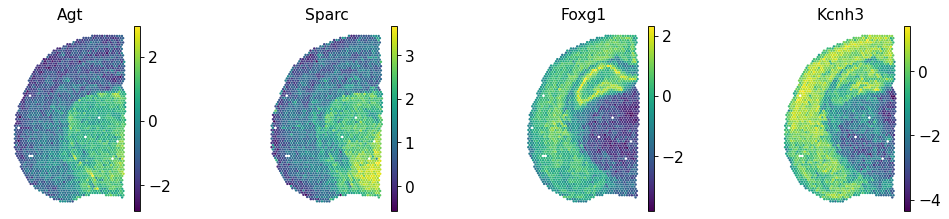

In [14]:
sc.pl.spatial(adata_scvi, color=list(adata_scvi.var.sort_values("spatial_information", ascending=False).index[0:4]), size=1.5, img_key=None)

### Low organization genes

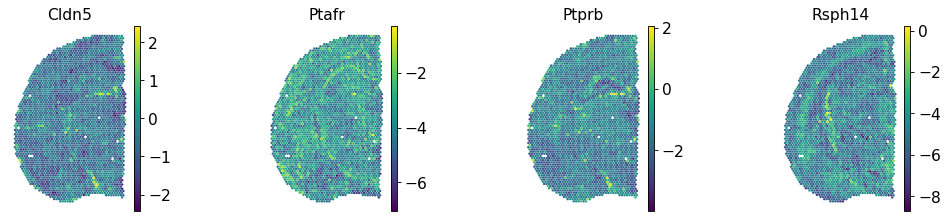

In [15]:
sc.pl.spatial(adata_scvi, color=list(adata_scvi.var.sort_values("spatial_information", ascending=True).index[0:4]), size=1.5, img_key=None)

## Pairwise spatial information

Next, we'll try to use pairwise spatial information to learn a bit more about how gene is expression is organized in relation to other genes.

Computing pairwise spatial information for every pair of genes is largely intractable. It's not necessisarily that interesting either, because many genes with display nearly. identical patterns of expression.

A more tractable and interesting alternative, is to perform dimenionality reduction, and compute pairwise spatial information in that lower dimensional representation. Here we'll use NMF, which gives us a representation that can be interpreted as "meta-genes". Each meta-gene is a positively-weighted sum of genes.

In [16]:
Nnmf = 20
nmf = NMF(n_components=Nnmf, init='nndsvd', random_state=0)
W = nmf.fit_transform(np.exp(adata_scvi.X))
adata_nmf = sc.AnnData(
    X=W,
    layers={"log1p": np.log1p(W)},
    obsm=adata.obsm,
    obs=adata.obs,
    obsp=adata.obsp,
    uns=adata.uns)

/home/dcjones/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


First let's compute spatial information on the meta-genes. We'll do this without uncertainty estimates. Because each meta-gene is a weighted sum of a bunch of genes, estimation uncertainty will be pretty minimal.

In [17]:
spatial_information(adata_nmf, layer="log1p", prior=None)

nsamples: 1
ngenes: 20
ncells: [2894, 723, 361, 180]
chunk size: 20


Scoring genes 0 to 20:  20%|████████████████▌                                                                  | 1600/8000 [00:10<00:42, 151.95it/s, mean_mi_bound=26.67992]


Loss plateaued. Quitting early.


### High organization NMF components

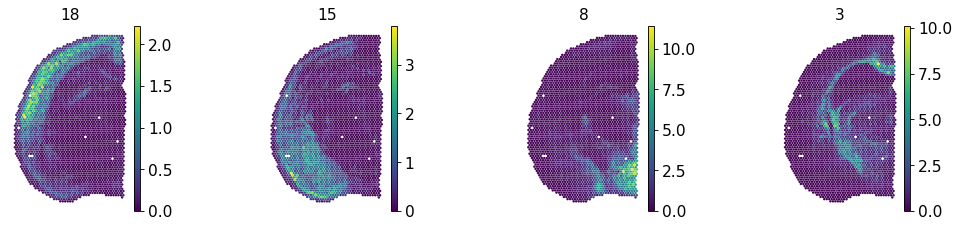

In [18]:
sc.pl.spatial(adata_nmf, color=list(adata_nmf.var.sort_values("spatial_information", ascending=False).index[0:4]), size=1.5, img_key=None)

### Low organization NMF components

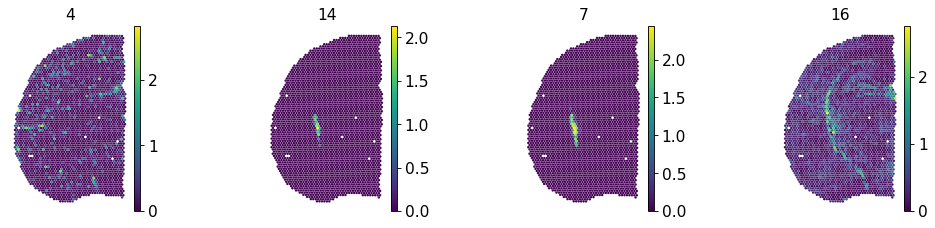

In [19]:
sc.pl.spatial(adata_nmf, layer="log1p", color=list(adata_nmf.var.sort_values("spatial_information", ascending=True).index[0:4]), size=1.5, img_key=None)

Next, we can compute pairwise spatial information between each meta-gene.

In [20]:
pairwise_spatial_information(adata_nmf, layer="log1p", prior=None)

nsamples: 1
ngenes: 20
4
ncells: [2894, 723, 361, 180]
chunk size: 20
Scoring all pairs with gene 0


Scoring genes 0 to 20:   6%|████▊                                                                                | 450/8000 [00:05<01:29, 84.00it/s, mean_mi_bound=1.011873]


Loss plateaued. Quitting early.
Scoring all pairs with gene 1


Scoring genes 0 to 20:   6%|█████▏                                                                            | 500/8000 [00:01<00:23, 320.64it/s, mean_mi_bound=0.24077766]


Loss plateaued. Quitting early.
Scoring all pairs with gene 2


Scoring genes 0 to 20:   9%|███████▊                                                                           | 750/8000 [00:02<00:22, 322.95it/s, mean_mi_bound=1.3623585]


Loss plateaued. Quitting early.
Scoring all pairs with gene 3


Scoring genes 0 to 20:   8%|██████▎                                                                             | 600/8000 [00:01<00:23, 312.25it/s, mean_mi_bound=-2.01609]


Loss plateaued. Quitting early.
Scoring all pairs with gene 4


Scoring genes 0 to 20:   4%|███▋                                                                                | 350/8000 [00:01<00:24, 310.90it/s, mean_mi_bound=1.057839]


Loss plateaued. Quitting early.
Scoring all pairs with gene 5


Scoring genes 0 to 20:  10%|████████▎                                                                          | 800/8000 [00:02<00:22, 323.42it/s, mean_mi_bound=4.0757184]


Loss plateaued. Quitting early.
Scoring all pairs with gene 6


Scoring genes 0 to 20:   8%|██████▏                                                                           | 600/8000 [00:01<00:23, 310.08it/s, mean_mi_bound=-1.4406979]


Loss plateaued. Quitting early.
Scoring all pairs with gene 7


Scoring genes 0 to 20:   2%|██                                                                                | 200/8000 [00:00<00:26, 291.20it/s, mean_mi_bound=-3.3098085]


Loss plateaued. Quitting early.
Scoring all pairs with gene 8


Scoring genes 0 to 20:   9%|███████▉                                                                            | 750/8000 [00:02<00:21, 333.74it/s, mean_mi_bound=3.292479]


Loss plateaued. Quitting early.
Scoring all pairs with gene 9


Scoring genes 0 to 20:  10%|████████▏                                                                         | 800/8000 [00:02<00:22, 321.61it/s, mean_mi_bound=0.93711805]


Loss plateaued. Quitting early.
Scoring all pairs with gene 10


Scoring genes 0 to 20:   8%|██████▋                                                                            | 650/8000 [00:01<00:22, 331.66it/s, mean_mi_bound=2.4000952]


Loss plateaued. Quitting early.
Scoring all pairs with gene 11


Scoring genes 0 to 20:   7%|█████▌                                                                           | 550/8000 [00:01<00:23, 319.90it/s, mean_mi_bound=-0.07890725]


Loss plateaued. Quitting early.
Scoring all pairs with gene 12


Scoring genes 0 to 20:   8%|██████▏                                                                            | 600/8000 [00:01<00:23, 315.45it/s, mean_mi_bound=1.8765097]


Loss plateaued. Quitting early.
Scoring all pairs with gene 13


Scoring genes 0 to 20:   9%|███████▊                                                                           | 750/8000 [00:02<00:21, 331.29it/s, mean_mi_bound=3.1618276]


Loss plateaued. Quitting early.
Scoring all pairs with gene 14


Scoring genes 0 to 20:   2%|██                                                                                | 200/8000 [00:00<00:28, 273.94it/s, mean_mi_bound=-2.8721366]


Loss plateaued. Quitting early.
Scoring all pairs with gene 15


Scoring genes 0 to 20:  12%|██████████▏                                                                      | 1000/8000 [00:03<00:21, 323.83it/s, mean_mi_bound=-1.3623128]


Loss plateaued. Quitting early.
Scoring all pairs with gene 16


Scoring genes 0 to 20:   6%|████▋                                                                              | 450/8000 [00:01<00:26, 289.47it/s, mean_mi_bound=0.8943354]


Loss plateaued. Quitting early.
Scoring all pairs with gene 17


Scoring genes 0 to 20:   6%|█████▏                                                                            | 500/8000 [00:01<00:24, 300.91it/s, mean_mi_bound=-2.3349035]


Loss plateaued. Quitting early.
Scoring all pairs with gene 18


Scoring genes 0 to 20:   9%|███████▏                                                                          | 700/8000 [00:02<00:23, 306.74it/s, mean_mi_bound=-0.7766033]


Loss plateaued. Quitting early.
Scoring all pairs with gene 19


Scoring genes 0 to 20:   6%|████▋                                                                               | 450/8000 [00:01<00:26, 283.59it/s, mean_mi_bound=1.678027]


Loss plateaued. Quitting early.


To explore these pairwise spatial information scores, we'll use hierarchical clustering. Hierarchical clustering expects a distance matrix, so we'll transform the pairwise information scores into a quasi-distance first.

In [21]:
I = np.clip(adata_nmf.varp["pairwise_spatial_information"], a_min=0.0, a_max=np.inf) # pairwise information matrix
D = 1/np.sqrt(1+I)

In [22]:
hclust = AgglomerativeClustering(
    affinity="precomputed",
    distance_threshold=0.0,
    n_clusters=None,
    linkage="average").fit(D)

Borrowing a little code, we can make a nice dendogram plot showing the spatial co-organization of the meta-genes.

In [23]:
# From here: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [24]:
sc.set_figure_params(frameon=False, figsize=[6, 5], ipython_format="png")

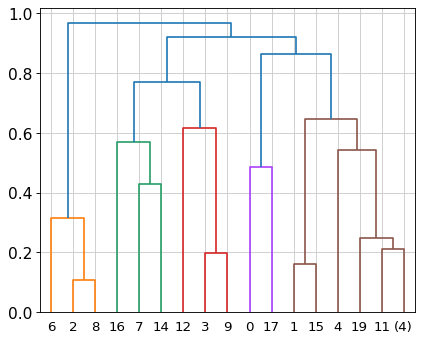

In [25]:
plot_dendrogram(hclust, truncate_mode="level", p=6)

Ploting a few neighboring meta-genes, we can see the resemblence in spatial organization.

In [26]:
sc.set_figure_params(frameon=False, figsize=[3, 3], ipython_format="png")

In [27]:
nearest_pair = next(filter(lambda ij: ij[0] != ij[1], zip(*np.unravel_index(np.argsort(np.ravel(-I)), (I.shape[0], I.shape[0])))))

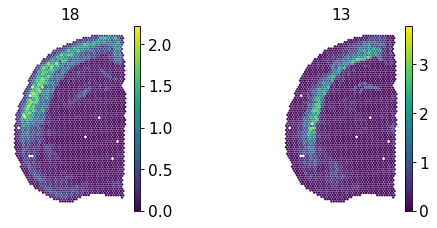

In [28]:
sc.pl.spatial(adata_nmf, color=map(str, nearest_pair), size=1.5, img_key=None)

Meta-genes are weighted sums of genes, so they are closed under addition. Each internal node in this dendogram is another meta-gene! So we can visualize a tree of meta-genes starting from the root.

In [29]:
parents = {}
for i in range(hclust.children_.shape[0]):
    left, right = hclust.children_[i]
    parents[left] = Nnmf + i
    parents[right] = Nnmf + i

In [30]:
# Expression for every meta-gene in the tree
Z = np.zeros((adata_nmf.shape[0], 2*Nnmf-1), dtype=adata_nmf.X.dtype)
for i in range(Nnmf):
    Z[:,i] += adata_nmf.X[:,i]
    j = i
    while j in parents:
        Z[:,parents[j]] += Z[:,j]
        j = parents[j]

In [31]:
adata_nmf_tree = sc.AnnData(
    X=np.log1p(Z),
    obsm=adata.obsm,
    obsp=adata.obsp,
    uns=adata.uns)

In [32]:
def plot_tree_layer(layer, root=2*Nnmf-2):
    nodes = []
    def traverse(i, depth):
        if depth == layer:
            nodes.append(i)
        else:
            for j in hclust.children_[i - Nnmf,:]:
                traverse(j, depth+1)
    traverse(root, 0)
    sc.pl.spatial(adata_nmf_tree, color=map(str, nodes), size=1.5, img_key=None, wspace=0.0, ncols=8)

Plotting the tree layer by layer, we can see the data decomposed into a hierarchy of increasingly specific meta-genes.

In [33]:
sc.set_figure_params(frameon=False, figsize=[3, 3], ipython_format="png")

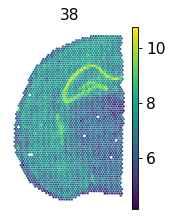

In [34]:
plot_tree_layer(0)

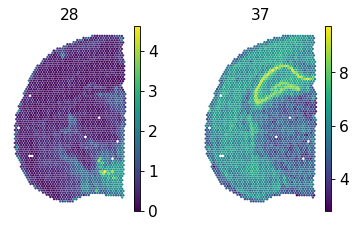

In [35]:
plot_tree_layer(1)

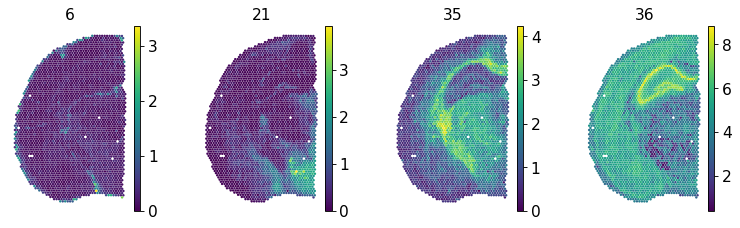

In [36]:
plot_tree_layer(2)

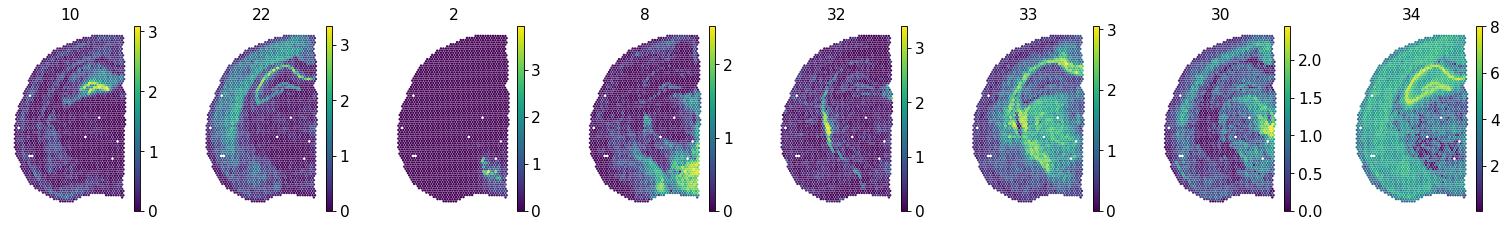

In [37]:
plot_tree_layer(3)